In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from skimage import data
from skimage.color import rgb2gray
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import data, exposure
import pandas as pd
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import RMSprop

In [2]:
# Caricamento del Dataset
classesName = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# Divisione con insieme di validazione formato dal % del train
percentuale = 0.1
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=percentuale, random_state=1)

In [4]:
# Normalizzazione in 0-1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

In [5]:
######################################################################################
###################### -- PANDAS DF -- ###############################################
######################################################################################

# Riduzione di dimensionalità x train
##  print(" - Creazione Df x train - ")

# -1 -> numero righe finali impostato in automatico
# 3072 -> numero colonne che deriva da 32*32*3
# - in questo modo ogni riga corrisponde a un'immagine e ogni colonna il valore di un pixel in un'unico canale colore
x_train_flat = x_train.reshape(-1,3072)

# Creazione di una lista di nomi di pixel dal primo all'ultimo che compone un'immagine
# - utile in seguito in modo da assegnare nome a colonne del Data Frame Pandas
feat_cols = ['pixel'+str(i) for i in range(x_train_flat.shape[1])]

# Creazione del dataframe pandas
df_cifar = pd.DataFrame(x_train_flat,columns=feat_cols)

##  print("Shape di df_cifar : ")
##  print(df_cifar.shape)
##  print("")

# Assegnazione delle etichette ai valori nel dataframe
df_cifar['label'] = y_train

##  print("Shape del df_cifar dopo aggiunta etichette : ")
##  print(df_cifar.shape)


# Riduzione di dimensionalità x val
x_val_flat = x_val.reshape(-1,3072)
feat_cols_val = ['pixel'+str(i) for i in range(x_val_flat.shape[1])]
df_cifar_val = pd.DataFrame(x_val_flat,columns=feat_cols_val)
df_cifar_val['label'] = y_val


# Riduzione di dimensionalità x test
x_test_flat = x_test.reshape(-1,3072)
feat_cols_test = ['pixel'+str(i) for i in range(x_test_flat.shape[1])]
df_cifar_test = pd.DataFrame(x_test_flat,columns=feat_cols_test)
df_cifar_test['label'] = y_test

In [6]:
################################################################################

# Utilizzo di PCA su TRAIN

# n_components è il numero di componenti che vogliamo valutare come obiettivo
pca_train = PCA(0.9)

# Estrazione di tutti i dati tranne ultima colonna che contiene le etichette
# - principalComponents_cifar è il risultato della riduzione di dimensionalità
principalComponents_cifar = pca_train.fit_transform(df_cifar.iloc[:,:-1])

print("\n Numero caratteristiche individuate : ",pca_train.n_components_)

################################################################################

# Utilizzo di PCA su TEST
pca_test = PCA(n_components=pca_train.n_components_)
principalComponents_cifar_test = pca_test.fit_transform(df_cifar_test.iloc[:,:-1])

################################################################################

# Utilizzo di PCA su VAL
pca_val = PCA(n_components=pca_train.n_components_)
principalComponents_cifar_val = pca_val.fit_transform(df_cifar_val.iloc[:,:-1])



 Numero caratteristiche individuate :  99


In [7]:
################################################################################

##  print("Assegnazione nome colonne a DF ottenuto x TRAIN")

# DF = Data Frame

# Creazione di nuovo data frame
# - partendo da quello appena ottenuto
# - vengono aggiunti i nomi dei valori contenuti
pca_cifar_Df = pd.DataFrame(data = principalComponents_cifar)

##  print("")

# Aggiunta della colonna con le etichette dei dati relativi
# - Lo faccio in una copia del dataframe così da averne uno senza etichette
##  print("Creazione dataframe con etichette come ultima colonna")
pca_cifar_Df_con_etichette = pca_cifar_Df.copy()
pca_cifar_Df_con_etichette['y'] = y_train


################################################################################

print("Assegnazione nome colonne a DF ottenuto x TEST")
pca_cifar_Df_test = pd.DataFrame(data = principalComponents_cifar_test)
print("")
print("Creazione dataframe con etichette come ultima colonna x test")
pca_cifar_Df_con_etichette_test = pca_cifar_Df_test.copy()
pca_cifar_Df_con_etichette_test['y'] = y_test

################################################################################

print("Assegnazione nome colonne a DF ottenuto x val")
pca_cifar_Df_val = pd.DataFrame(data = principalComponents_cifar_val)
print("")
print("Creazione dataframe con etichette come ultima colonna x val")
pca_cifar_Df_con_etichette_val = pca_cifar_Df_val.copy()
pca_cifar_Df_con_etichette_val['y'] = y_val

Assegnazione nome colonne a DF ottenuto x TEST

Creazione dataframe con etichette come ultima colonna x test
Assegnazione nome colonne a DF ottenuto x val

Creazione dataframe con etichette come ultima colonna x val


In [8]:
# - Preparazione dei dataset filtrati

# Prova di divisione in due classi
primaEtichetta = 4
secondaEtichetta = 9

df_filtrato_etichettato = pca_cifar_Df_con_etichette[pca_cifar_Df_con_etichette['y'].isin([primaEtichetta,secondaEtichetta])]
df_filtrato_etichettato_test = pca_cifar_Df_con_etichette_test[pca_cifar_Df_con_etichette_test['y'].isin([primaEtichetta,secondaEtichetta])]
df_filtrato_etichettato_val = pca_cifar_Df_con_etichette_val[pca_cifar_Df_con_etichette_val['y'].isin([primaEtichetta,secondaEtichetta])]

# Filtro i dati delle etichette
y_train_filtrato = y_train[np.isin(y_train, [primaEtichetta,secondaEtichetta])]
y_test_filtrato = y_test[np.isin(y_test, [primaEtichetta,secondaEtichetta])]
y_val_filtrato = y_val[np.isin(y_val, [primaEtichetta,secondaEtichetta])]

# Eliminazione colonna etichette
df_filtrato = df_filtrato_etichettato.copy()
df_filtrato = df_filtrato.drop(columns=['y'])

# Eliminazione colonna etichette
df_filtrato_test = df_filtrato_etichettato_test.copy()
df_filtrato_test = df_filtrato_test.drop(columns=['y'])

# Eliminazione colonna etichette
df_filtrato_val = df_filtrato_etichettato_val.copy()
df_filtrato_val = df_filtrato_val.drop(columns=['y'])

In [9]:
# CLASSIFICAZIONE con Random Forest su set filtrato

# -> Parametri migliori trovati

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

##  AdaBoostClassifier(estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
clf = AdaBoostClassifier(n_estimators=80, learning_rate=0.7,algorithm="SAMME", random_state=0)
clf.fit(df_filtrato, y_train_filtrato);

print("Test Score AdaBOOST 250 : " , clf.score(df_filtrato_test, y_test_filtrato))
print("Train Score AdaBOOST 250 : " , clf.score(df_filtrato, y_train_filtrato))

Test Score AdaBOOST 250 :  0.8195
Train Score AdaBOOST 250 :  0.8614955357142857



Test Score AdaBOOST  10  :  0.7645
Train Score AdaBOOST  10  :  0.7967633928571428

Test Score AdaBOOST  20  :  0.78
Train Score AdaBOOST  20  :  0.8084821428571428

Test Score AdaBOOST  40  :  0.793
Train Score AdaBOOST  40  :  0.8245535714285714

Test Score AdaBOOST  80  :  0.8005
Train Score AdaBOOST  80  :  0.84296875

Test Score AdaBOOST  150  :  0.8135
Train Score AdaBOOST  150  :  0.8645089285714286

Test Score AdaBOOST  300  :  0.8215
Train Score AdaBOOST  300  :  0.8845982142857143

Test Score AdaBOOST  600  :  0.8255
Train Score AdaBOOST  600  :  0.89453125
[0.7645, 0.78, 0.793, 0.8005, 0.8135, 0.8215, 0.8255]


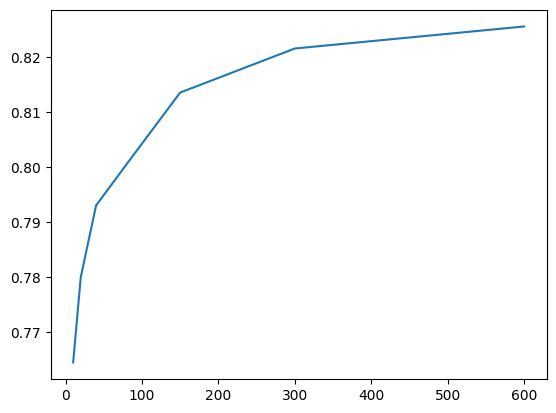

In [11]:
'''
# TUNING PARAMETRICO : n_estimators

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

prove = [10,20,40,80,150,300,600]

risultatiTest = []
risultatiTrain = []

c=0
for i in prove:
    clf = AdaBoostClassifier(n_estimators=i, learning_rate=0.4,algorithm="SAMME", random_state=0)
    clf.fit(df_filtrato, y_train_filtrato)
    risultatiTest.append(clf.score(df_filtrato_test, y_test_filtrato))
    risultatiTrain.append(clf.score(df_filtrato, y_train_filtrato))
    print("\nTest Score AdaBOOST ",i," : " , risultatiTest[c])
    print("Train Score AdaBOOST ",i," : " , risultatiTrain[c])
    c = c+1

print(risultatiTest)
plt.plot(prove,risultatiTest)
plt.show()
'''


Test Score AdaBOOST  0.1  :  0.7845
Train Score AdaBOOST  0.1  :  0.8125

Test Score AdaBOOST  0.2  :  0.782
Train Score AdaBOOST  0.2  :  0.8243303571428572

Test Score AdaBOOST  0.3  :  0.8035
Train Score AdaBOOST  0.3  :  0.8319196428571428

Test Score AdaBOOST  0.4  :  0.8005
Train Score AdaBOOST  0.4  :  0.84296875

Test Score AdaBOOST  0.5  :  0.8085
Train Score AdaBOOST  0.5  :  0.85

Test Score AdaBOOST  0.6  :  0.818
Train Score AdaBOOST  0.6  :  0.8603794642857143

Test Score AdaBOOST  0.7  :  0.8195
Train Score AdaBOOST  0.7  :  0.8614955357142857

Test Score AdaBOOST  0.8  :  0.8135
Train Score AdaBOOST  0.8  :  0.8625

Test Score AdaBOOST  0.9  :  0.8015
Train Score AdaBOOST  0.9  :  0.8667410714285714

Test Score AdaBOOST  1  :  0.8165
Train Score AdaBOOST  1  :  0.8689732142857143
[0.7845, 0.782, 0.8035, 0.8005, 0.8085, 0.818, 0.8195, 0.8135, 0.8015, 0.8165]


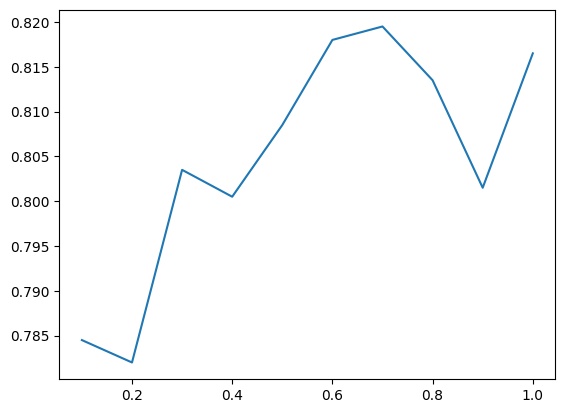

In [12]:
'''
# TUNING PARAMETRICO : learning_rate

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

prove = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

risultatiTest = []
risultatiTrain = []

c=0
for i in prove:
    clf = AdaBoostClassifier(n_estimators=80, learning_rate=i,algorithm="SAMME", random_state=0)
    clf.fit(df_filtrato, y_train_filtrato)
    risultatiTest.append(clf.score(df_filtrato_test, y_test_filtrato))
    risultatiTrain.append(clf.score(df_filtrato, y_train_filtrato))
    print("\nTest Score AdaBOOST ",i," : " , risultatiTest[c])
    print("Train Score AdaBOOST ",i," : " , risultatiTrain[c])
    c = c+1

print(risultatiTest)
plt.plot(prove,risultatiTest)
plt.show()
'''